In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom

print(tf.__version__) # 2.6.0

2.6.0


In [2]:
from pathlib import Path

# Obter todas as fotos de caule
path = Path( 'fotos/by_plant/caule' )
img_count = len( list(path.glob('*.jpg')) )

In [3]:
# Vou usar o seguinte esquema:
# 80% das imagens serão usadas para treinar a ML
# 20% para validar a precisão
batch_size = 1
img_width = 100
img_height = 100

In [4]:
# Criar dataset para treinamento
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 99 files belonging to 5 classes.
Using 80 files for training.


2021-11-01 22:38:11.954683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-01 22:38:12.007783: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# Criar dataset para validação
val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size
)

Found 99 files belonging to 5 classes.
Using 19 files for validation.


In [6]:
class_names = train_ds.class_names
print( class_names )

['caesalpinia_pulcherrima', 'chamaecrista_desvauxii', 'crotalaria_retusa', 'hymenaea_coubaril', 'leucaena_leucocephala']


In [7]:
# Remover canal gama RGB (vai basicamente deixar todas as fotos em preto e branco)
normalization_layer = Rescaling(1. / 255)

In [8]:
# Normalizar imagens
normalized_ds = train_ds.map( lambda x, y: (normalization_layer(x), y) )

# Checar se a imagem agora está normalizada
# obs: uma imagem normalizada deve ter os valores
# dos pixels entre 0.0 e 1.0
image_batch, labels_batch = next( iter(normalized_ds) )
first_image = image_batch[0]
print( np.min(first_image), np.max(first_image) )

2021-11-01 22:38:13.931607: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


0.0 1.0


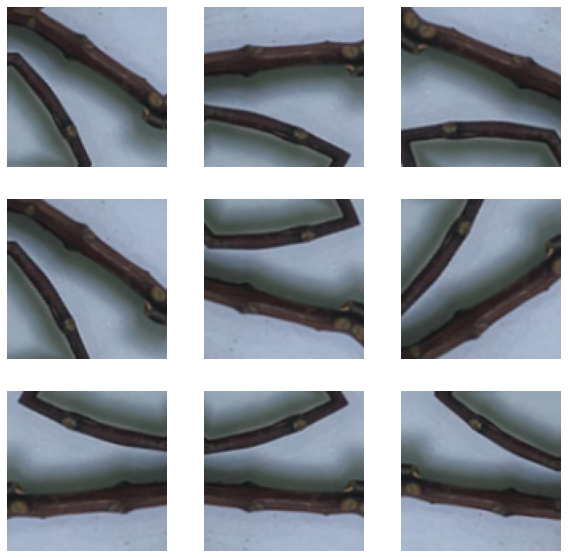

In [9]:
# Aumento de dados
# como o dataset de imagens é bem pequeno, vamos aplicar
# técnicas como zoom, espelhar e rotacionar as imagens
# existentes, criando cópias com essas modificações
# para serem inclusas no treinamento
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Visualização das imagens com modificações
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [10]:
# Criação do modelo
num_classes = 5
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])

In [11]:
# Compilar o modelo
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Exibir resumo do modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)       

In [12]:
# Treinar o modelo
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
80/80 [==============================] - 8s 74ms/step - loss: 1.6706 - accuracy: 0.2250 - val_loss: 1.8039 - val_accuracy: 0.0526
Epoch 2/100
80/80 [==============================] - 5s 63ms/step - loss: 1.4862 - accuracy: 0.3500 - val_loss: 1.5069 - val_accuracy: 0.2632
Epoch 3/100
80/80 [==============================] - 5s 56ms/step - loss: 1.4966 - accuracy: 0.4000 - val_loss: 1.2270 - val_accuracy: 0.4737
Epoch 4/100
80/80 [==============================] - 5s 59ms/step - loss: 1.3215 - accuracy: 0.5125 - val_loss: 1.2482 - val_accuracy: 0.2632
Epoch 5/100
80/80 [==============================] - 5s 64ms/step - loss: 1.1127 - accuracy: 0.5500 - val_loss: 1.1207 - val_accuracy: 0.3684
Epoch 6/100
80/80 [==============================] - 5s 64ms/step - loss: 1.2133 - accuracy: 0.4625 - val_loss: 1.1760 - val_accuracy: 0.3158
Epoch 7/100
80/80 [==============================] - 5s 57ms/step - loss: 1.1920 - accuracy: 0.5250 - val_loss: 0.9972 - val_accuracy: 0.5263
Epoch 

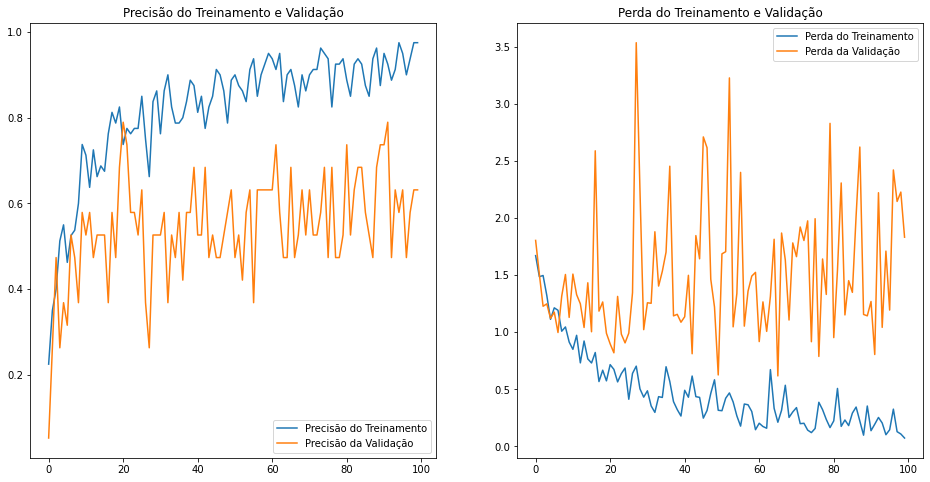

In [13]:
# Estatisticas sobre o treinamento e validação
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plotar gráficos de precisão e perda
plt.figure( figsize=(16, 8) )
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisão do Treinamento')
plt.plot(epochs_range, val_acc, label='Precisão da Validação')
plt.legend(loc='lower right')
plt.title('Precisão do Treinamento e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda do Treinamento')
plt.plot(epochs_range, val_loss, label='Perda da Validação')
plt.legend(loc='upper right')
plt.title('Perda do Treinamento e Validação')
plt.show()

In [14]:
# Testar a ML
img = tf.keras.utils.load_img(
    'fotos/testes/Caule10LL.jpg', target_size=(img_width, img_height)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax( predictions[0] )
print( f"Essa imagem provavelmente pertence à classe '{ class_names[ np.argmax(score) ] }' com uma confiança de {(100 * np.max(score)):.2f}%" )

Essa imagem provavelmente pertence à classe 'leucaena_leucocephala' com uma confiança de 99.97%


In [15]:
# Exportar o modelo
model.save('models/caule.h5')